In [1]:
from proj1_helpers import *
from implementations import *
from costs import *
from data_helper import *
from plots import *

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = 'data/'
PREDICTION_PATH = 'predictions/'

In [3]:
##Import training data
y_tr, x_tr, ids_tr = load_csv_data(DATA_PATH + "train.csv")

print('y_tr.shape =', y_tr.shape)
print('x_tr.shape =', x_tr.shape)
print('ids_tr.shape =', ids_tr.shape)

y_tr.shape = (250000,)
x_tr.shape = (250000, 30)
ids_tr.shape = (250000,)


In [47]:
# Import Test data
y_te, x_te, ids_te = load_csv_data(DATA_PATH + "test.csv")

print('y_te.shape =', y_te.shape)
print('x_te.shape =', x_te.shape)
print('ids_te.shape =', ids_te.shape)

y_te.shape = (568238,)
x_te.shape = (568238, 30)
ids_te.shape = (568238,)


# Additionnal Function

In [31]:
def fast_buildpoly(x,ma,degree):
    return np.c_[ma,np.power(x, degree)]

In [77]:
def filter_sub(x_sub,ind=True):
    ## This Function Clean the subset data
    
    ## This loop count the number of outliers in the columns, if the column is full of outlier, It is removed.
    idex = []
    for i in range(len(np.transpose(x_sub))):
        j = 0
        for x in np.transpose(x_sub)[i]:
            if x==-999 or x == 0:
                   j += 1
        if j == len(x_sub):
               idex.append(i)
    ## If sup is True the function delete the "index" columns (line 22 of the data). 
    if ind:
        idex.append(22) 
    x_without_er = np.delete(x_sub,idex,1)
    

    x_without_er=set_missing_values_to_mean(x_without_er)
    ## This loop, find columns that are strongly correlate and delete one of them
    idex=[]
    for i in range(len(x_without_er.T)):
        
        for j in range(len(x_without_er.T)):
            
            if i != j and i < j:
                corr = np.abs(np.corrcoef(x_without_er.T[j], x_without_er.T[i])[1][0])
                if corr > 0.9:
                    idex.append(i)
                    
    x_fin = np.delete(x_without_er,idex,1)
    
    return x_fin , np.mean(x_fin,axis=0), np.std(x_fin,axis=0)

## Divide into Subset

In [78]:
x_sub0=[]
x_sub1=[]
x_sub2=[]
y_sub0=[]
y_sub1=[]
y_sub2=[]
for i in range(len(x_tr)):
    if x_tr[i][22] == 0:
        x_sub0.append(x_tr[i])
        y_sub0.append(y_tr[i])
    elif x_tr[i][22] == 1:
        x_sub1.append(x_tr[i])
        y_sub1.append(y_tr[i])
    else:
        x_sub2.append(x_tr[i])
        y_sub2.append(y_tr[i])

In [79]:
def apply_least_squares(x,y,maxdegree):
    degrees = np.arange(maxdegree) + 1
    acc = []
    we=[]
    
    poly = np.ones((x.shape[0], 1))
    
    for degree in degrees:
        poly = fast_buildpoly(x,poly, degree)
        w, loss = least_squares(y, poly)
        we.append(w)
        acc.append(compute_categorical_loss(y, poly, w))
        
    plt.plot(degrees, acc, 'r') 
    plt.xlabel('Degree')
    plt.ylabel('Error')
    plt.show()
    print('Min =', min(acc))
    print('Best degree =', acc.index(min(acc)) + 1)
    return we[acc.index(min(acc))] 

## Train subset 0

In [80]:
xfsub0, mean0, std0 = filter_sub(x_sub0)
# Standardize the dataset
xfsub_0 = (xfsub0-mean0)/std0
y_sub0 = np.array(y_sub0)

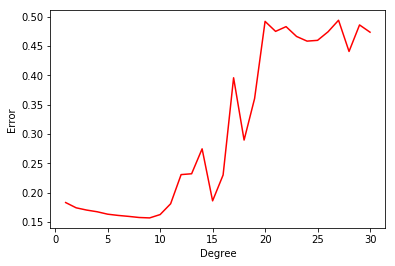

Min = 0.15687648254
Best degree = 9


In [81]:
w_0=apply_least_squares(xfsub_0,y_sub0,30)

## Train Subset 1

In [82]:
xfsub_1, mean1, std1 = filter_sub(x_sub1)
xfsub_1 = (xfsub_1-mean1)/std1
y_sub1  = np.array(y_sub1)

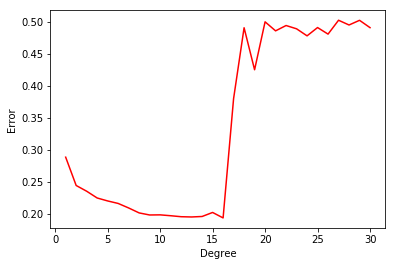

Min = 0.193193541731
Best degree = 16


In [83]:
w_1=apply_least_squares(xfsub_1,y_sub1,30)

## Train subset 2:

In [84]:
xfsub_2, mean2, std2 = filter_sub(x_sub2,ind=False)
xfsub_2 = (xfsub_2-mean2)/std2
y_sub2  = np.array(y_sub2)

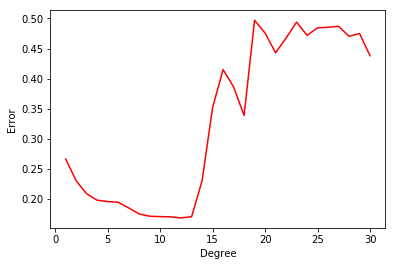

Min = 0.168534524351
Best degree = 12


In [85]:
w_2 = apply_least_squares(xfsub_2,y_sub2,30)

## Create The Prediction

In [86]:
xte_sub0 = []
xte_sub1 = []
xte_sub2= []

xte_ind = []

for i in range(len(x_te)):
    if x_te[i][22]==0:
        xte_sub0.append(x_te[i])
        xte_ind.append(0)
    elif x_te[i][22]==1:
        xte_sub1.append(x_te[i])
        xte_ind.append(1)
    else:
        xte_sub2.append(x_te[i])
        xte_ind.append(2)

In [88]:
xfte_0, _, _ = filter_sub(xte_sub0)
xfte_0 = (xfte_0 - mean0) / std0
pol = build_poly(xfte_0,9)
yres0 = predict_labels(w_0,pol)

xfte_1,_,_ = filter_sub(xte_sub1)
xfte_1 = (xfte_1 - mean1) / std1
pol   = build_poly(xfte_1,16)
yres1 =predict_labels(w_1,pol)

xfte_2,_,_= filter_sub(xte_sub2,ind=False)
xfte_2=(xfte_2-mean2)/std2
pol=build_poly(xfte_2,12)
yres23=predict_labels(w_2,pol)

In [ ]:
in0=0
in1=0
in2=0
yresf=[]
for i in range(len(x_te)):
    if xte_ind[i]==0:
        yresf.append(yres0[in0])
        in0+=1
    if xte_ind[i]==1:
        yresf.append(yres1[in1])
        in1+=1
    if xte_ind[i]==2:
        yresf.append(yres23[in2])
        in2+=1

In [ ]:
print(np.shape(yresf))
create_csv_submission(ids_te, yresf, "ModelFin_3.csv")